In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [67]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [68]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [69]:
Image_RGB.shape

(14142, 64, 64, 5)

In [70]:
#Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

In [71]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)
total  14142  samples


In [75]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 200
#intermediate_dim_2 = 300
original_dim = 64*64

LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation=LRelu)(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation=LRelu)(z)
h_5 = Dense(80*2*2,activation=LRelu)(h_4)
h_6 = Reshape((2,2,80))(h_5)


conv_6 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation=LRelu,padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [76]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=10,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:9500],train_data[8000:9500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 1500 samples
Epoch 1/10
8000/8000 [==============================] - 24s - loss: -8015.5042 - val_loss: -9480.0480
Epoch 2/10
8000/8000 [==============================] - 22s - loss: -9442.0209 - val_loss: -9563.7116
Epoch 3/10
8000/8000 [==============================] - 22s - loss: -9586.0469 - val_loss: -9622.4466
Epoch 4/10
8000/8000 [==============================] - 22s - loss: -9640.4868 - val_loss: -9673.1388
Epoch 5/10
8000/8000 [==============================] - 22s - loss: -9663.5503 - val_loss: -9679.7974
Epoch 6/10
8000/8000 [==============================] - 22s - loss: -9671.2332 - val_loss: -9675.1551
Epoch 7/10
8000/8000 [==============================] - 22s - loss: -9691.8268 - val_loss: -9693.0250
Epoch 8/10
8000/8000 [==============================] - 22s - loss: -9697.8931 - val_loss: -9698.1332
Epoch 9/10
8000/8000 [==============================] - 22s - loss: -9702.5292 - val_loss: -9604.2768
Epoch 10/10
8000/8000 [===========

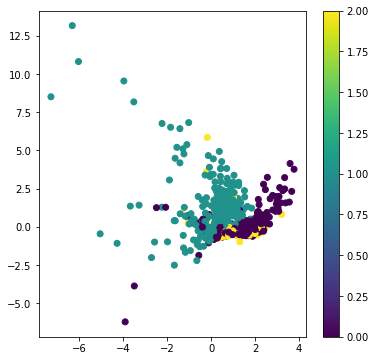

In [77]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])
test_data = train_data[8000:9000]
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(test_data, batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()

In [78]:
size = np.zeros((len(test_data),))
threshold = np.zeros_like(test_data)
pixel_sum = np.zeros((len(test_data),))
threshold[test_data>np.mean(test_data)]=1

for i in range(len(x_vis)):
    pixel_sum[i] = np.sum(test_data[i])
    size[i] = np.sum(threshold[i])
    #train_data[8000:9000]
    

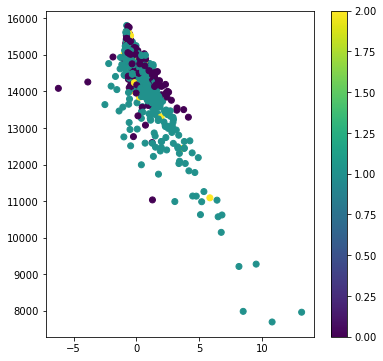

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 1] ,size,c=label_value[8000:9000])
plt.colorbar()
plt.show()

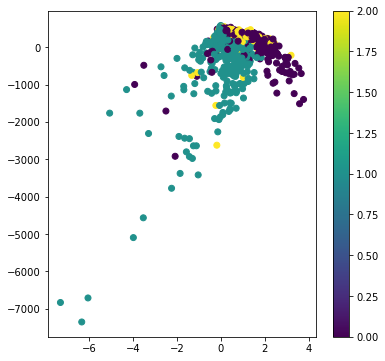

In [80]:
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,pixel_sum,c=label_value[8000:9000])
plt.colorbar()
plt.show()

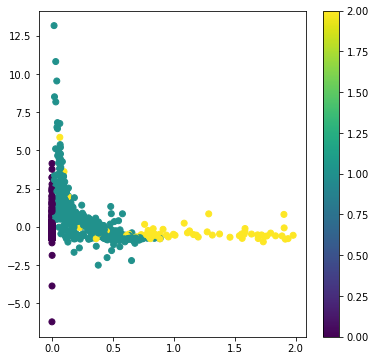

In [81]:
plt.figure(figsize=(6, 6))
plt.scatter( Redshift[8000:9000],x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()

# Regression for Redshift

In [101]:
batch_size =100
latent_dim = 1
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 300
#intermediate_dim_2 = 300
original_dim = 64*64

LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

input_img = Input(shape=(64,64,5))
x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(input_img)
x = Dropout(0.25)(x)


conv_1 = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)
maxpool_1 = Dropout(0.25)(maxpool_1)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_1)
x = Dropout(0.25)(x)

conv_2 = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)
maxpool_2 = Dropout(0.25)(maxpool_2)

x = Conv2D(40, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_2)
x = Dropout(0.25)(x)

conv_3 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(x)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)
maxpool_3 = Dropout(0.25)(maxpool_3)

conv_4 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)
maxpool_4 = Dropout(0.25)(maxpool_4)

conv_5 = Conv2D(20, (3, 3), activation=LRelu, padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)
maxpool_5 = Dropout(0.25)(maxpool_5)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation=LRelu)(visual)
h_1 = Dropout(0.25)(h_1)
redshift = Dense(latent_dim, activation='sigmoid')(h_1)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


model = Model(inputs=input_img, outputs=redshift) 
model.compile(optimizer='rmsprop', loss='mean_squared_error') 

In [102]:
model.fit(train_data[:8000], Redshift[:8000]/2,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[8000:9500],Redshift[8000:9500]/2),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 1500 samples
Epoch 1/50
8000/8000 [==============================] - 16s - loss: 0.0513 - val_loss: 0.0567
Epoch 2/50
8000/8000 [==============================] - 15s - loss: 0.0501 - val_loss: 0.0569
Epoch 3/50
8000/8000 [==============================] - 15s - loss: 0.0504 - val_loss: 0.0569
Epoch 4/50
8000/8000 [==============================] - 15s - loss: 0.0510 - val_loss: 0.0483
Epoch 5/50
8000/8000 [==============================] - 15s - loss: 0.0332 - val_loss: 0.0477
Epoch 6/50
8000/8000 [==============================] - 15s - loss: 0.0277 - val_loss: 0.0302
Epoch 7/50
8000/8000 [==============================] - 15s - loss: 0.0262 - val_loss: 0.0230
Epoch 8/50
8000/8000 [==============================] - 15s - loss: 0.0175 - val_loss: 0.0204
Epoch 9/50
8000/8000 [==============================] - 15s - loss: 0.0162 - val_loss: 0.0179
Epoch 10/50
8000/8000 [==============================] - 15s - loss: 0.0154 - val_loss: 0.0179
Epoch 11/50

In [111]:
rdsft_predict = model.predict(train_data[100:150])

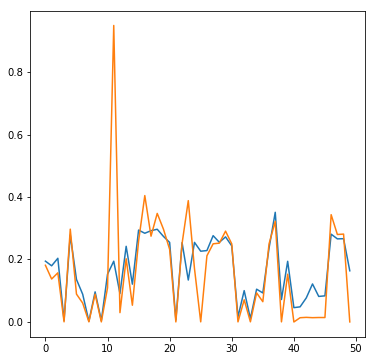

In [112]:
plt.figure(figsize=(6, 6))
plt.plot( rdsft_predict)
plt.plot(Redshift[100:150]/2)
#plt.colorbar()
plt.show()

In [109]:
rdsft_predict = model.predict(train_data[10000:10050])

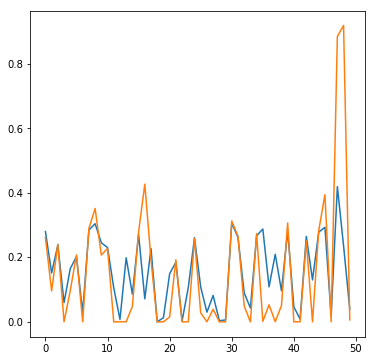

In [110]:
plt.figure(figsize=(6, 6))
plt.plot( rdsft_predict)
plt.plot(Redshift[10000:10050]/2)
#plt.colorbar()
plt.show()

In [116]:
red_pred_1 = model.predict(train_data[8000:8500])

In [117]:
train_data[0].shape

(64, 64, 5)

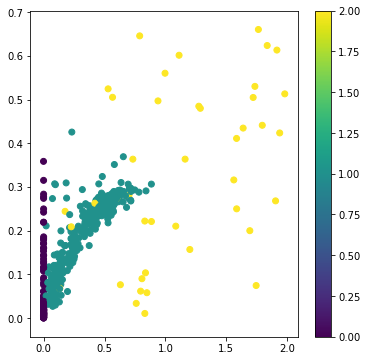

In [118]:
plt.figure(figsize=(6, 6))
plt.scatter( Redshift[8000:8500],red_pred_1,c=label_value[8000:8500])
plt.colorbar()
plt.show()